
# Softmax and Backpropagation — A Hands-on Guide (Python + LaTeX)

This notebook explains and illustrates the **softmax function** and **backward propagation** for a single linear layer with softmax + cross-entropy, using **NumPy** and **Matplotlib**. We include:
- Clear math derivations using LaTeX.
- Numerically stable softmax implementation.
- Backpropagation derivation and a **gradient check** with finite differences.
- Visualizations of logits/probabilities and a tiny training demo on synthetic data.



## LaTeX Math Formatting Quick Notes
- Inline: $\int_a^b f(x)\,dx = F(b)-F(a)$
- Display (centered):
$$
f'(a) = \lim_{x \to a} \frac{f(x) - f(a)}{x-a}
$$



## 1. Softmax — Definition and Properties

Given a vector of **logits** $\mathbf{z}\in\mathbb{R}^K$, the softmax function returns a probability vector $\hat{\mathbf{y}}\in\Delta^{K-1}$:
$$
\mathrm{softmax}(\mathbf{z})_k = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}, \quad k=1,\dots,K.
$$

Two key properties:

1. **Normalization:** $\sum_k \mathrm{softmax}(\mathbf{z})_k = 1$.
2. **Shift invariance:** for any constant $\alpha\in\mathbb{R}$,
$$
\mathrm{softmax}(\mathbf{z}) = \mathrm{softmax}(\mathbf{z} - \alpha \mathbf{1}).
$$

Thus, we implement a numerically stable softmax by subtracting the maximum logit from each row:
$$
\mathrm{softmax}(\mathbf{z})_k = \frac{e^{z_k - \max_j z_j}}{\sum_{j=1}^K e^{z_j - \max_i z_i}}.
$$


In [1]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

np.set_printoptions(precision=4, suppress=True)

def softmax(Z):
    Zs = Z - np.max(Z, axis=1, keepdims=True)
    E = np.exp(Zs)
    return E / np.sum(E, axis=1, keepdims=True)

def cross_entropy(y_true_onehot, y_prob):
    return -np.mean(np.sum(y_true_onehot * np.log(y_prob + 1e-9), axis=1))

def accuracy(y_true_labels, y_prob):
    pred = np.argmax(y_prob, axis=1)
    return np.mean(pred == y_true_labels)


## 2. Backpropagation for Linear Layer + Softmax + Cross-Entropy

Consider a batch of $N$ examples and $K$ classes. Let inputs be $\mathbf{X}\in\mathbb{R}^{N\times D}$,
weights $\mathbf{W}\in\mathbb{R}^{D\times K}$, bias $\mathbf{b}\in\mathbb{R}^{1\times K}$ (broadcast row-wise).

For a classification task with K classes, we have:

- $\mathbf{Y}$ is one-hot encoded ground truth: $Y_{ik}=1$ if example $i$ belongs to class $k$, otherwise 0.
- $\hat{\mathbf{Y}} = \mathrm{softmax}(\mathbf{Z})$ gives predicted probabilities, where $\hat{Y}_{ik}$ is the probability that example $i$ belongs to class $k$.
- The softmax ensures $\hat{Y}_{ik} \in [0,1]$ and $\sum_k \hat{Y}_{ik} = 1$ for all examples $i$.
- Cross-entropy measures the mismatch between true and predicted distributions.
- When $\mathbf{Y}$ is one-hot, only the true class $k^*$ contributes: $-\log \hat{Y}_{ik^*}$.


**Forward pass:**
\begin{align}
\mathbf{Z} &= \mathbf{X}\mathbf{W} + \mathbf{b} \quad (\in \mathbb{R}^{N\times K}) \\
\hat{\mathbf{Y}} &= \mathrm{softmax}(\mathbf{Z}) \quad (\in \mathbb{R}^{N\times K}) \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N \sum_{k=1}^K Y_{ik} \log \hat{Y}_{ik}
\end{align}

**Key identity (softmax + cross-entropy):**
$$
\boxed{\;\frac{\partial \mathcal{L}}{\partial \mathbf{Z}} = \hat{\mathbf{Y}} - \mathbf{Y}\;}
$$

**Deriving Parameter Gradients Step by Step:**

1. **Chain Rule Structure:**
   - We need $\frac{\partial \mathcal{L}}{\partial \mathbf{W}}$ and $\frac{\partial \mathcal{L}}{\partial \mathbf{b}}$
   - By chain rule: $\frac{\partial \mathcal{L}}{\partial \mathbf{W}} = \frac{\partial \mathbf{Z}}{\partial \mathbf{W}} \cdot \frac{\partial \mathcal{L}}{\partial \mathbf{Z}}$

2. **For Weight Matrix $\mathbf{W}$:**
   - From forward pass: $\mathbf{Z} = \mathbf{X}\mathbf{W} + \mathbf{b}$
   - Therefore: $\frac{\partial \mathbf{Z}}{\partial \mathbf{W}} = \mathbf{X}^\top$
   - Using the key identity above:
   $$\frac{\partial \mathcal{L}}{\partial \mathbf{W}} = \mathbf{X}^\top \cdot (\hat{\mathbf{Y}} - \mathbf{Y}) \cdot \frac{1}{N}$$

3. **For Bias Vector $\mathbf{b}$:**
   - From forward pass: $\mathbf{Z} = \mathbf{X}\mathbf{W} + \mathbf{b}$
   - $\frac{\partial \mathbf{Z}}{\partial \mathbf{b}} = 1$ (broadcasted)
   - Sum over batch dimension since bias is shared:
   $$\frac{\partial \mathcal{L}}{\partial \mathbf{b}} = \sum_{i=1}^N (\hat{\mathbf{Y}}_i - \mathbf{Y}_i) \cdot \frac{1}{N}$$

**Parameter gradients (final form):**
\begin{align}
\frac{\partial \mathcal{L}}{\partial \mathbf{W}} &= \frac{1}{N}\,\mathbf{X}^\top (\hat{\mathbf{Y}} - \mathbf{Y}) \\
\frac{\partial \mathcal{L}}{\partial \mathbf{b}} &= \frac{1}{N} \sum_{i=1}^N \big(\hat{\mathbf{Y}}_i - \mathbf{Y}_i\big)
\end{align}

**Gradient to inputs (if needed for deeper nets):**
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{X}} = (\hat{\mathbf{Y}} - \mathbf{Y})\,\mathbf{W}^\top.
$$

In [2]:

def linear_forward(X, W, b):
    return X @ W + b  # (N,K)

def forward_loss(X, W, b, Y_onehot):
    Z = linear_forward(X, W, b)
    P = softmax(Z)
    L = cross_entropy(Y_onehot, P)
    return L, P, Z

def backward_grads(X, W, b, Y_onehot, P):
    N = X.shape[0]
    dZ = (P - Y_onehot)                    # (N,K)
    dW = (X.T @ dZ) / N                    # (D,K)
    db = np.sum(dZ, axis=0, keepdims=True) / N  # (1,K)
    dX = dZ @ W.T                          # (N,D) if needed
    return dW, db, dX



## 3. Gradient Check (Finite Differences)
For a parameter $\theta$:
$$
\frac{\partial \mathcal{L}}{\partial \theta} \approx \frac{\mathcal{L}(\theta + h) - \mathcal{L}(\theta - h)}{2h}, \quad h\text{ small.}
$$


In [3]:
import numpy as np

# Tiny random problem for gradient checking
rng = np.random.default_rng(0)
N, D, K = 5, 4, 3
X_gc = rng.normal(size=(N, D))
W_gc = rng.normal(scale=0.1, size=(D, K))
b_gc = np.zeros((1, K))
y_labels_gc = rng.integers(0, K, size=N)
Y_gc = np.eye(K)[y_labels_gc]

L, P, _ = forward_loss(X_gc, W_gc, b_gc, Y_gc)
dW_anal, db_anal, _ = backward_grads(X_gc, W_gc, b_gc, Y_gc, P)

def loss_at(W, b):
    return forward_loss(X_gc, W, b, Y_gc)[0]

eps = 1e-5
dW_num = np.zeros_like(W_gc)
for i in range(D):
    for j in range(K):
        Wp = W_gc.copy(); Wp[i, j] += eps
        Wm = W_gc.copy(); Wm[i, j] -= eps
        dW_num[i, j] = (loss_at(Wp, b_gc) - loss_at(Wm, b_gc)) / (2*eps)

db_num = np.zeros_like(b_gc)
for j in range(K):
    bp = b_gc.copy(); bp[0, j] += eps
    bm = b_gc.copy(); bm[0, j] -= eps
    db_num[0, j] = (loss_at(W_gc, bp) - loss_at(W_gc, bm)) / (2*eps)

rel_W = np.linalg.norm(dW_anal - dW_num) / (np.linalg.norm(dW_anal) + np.linalg.norm(dW_num) + 1e-12)
rel_b = np.linalg.norm(db_anal - db_num) / (np.linalg.norm(dW_anal) + np.linalg.norm(dW_num) + 1e-12)

print("Gradient check:")
print("  relative error (W):", rel_W)
print("  relative error (b):", rel_b)


Gradient check:
  relative error (W): 1.4317822531156855e-09
  relative error (b): 7.914318856516565e-10



## 4. Visualizing Softmax Behavior (3-class)
We vary two logits while keeping the third fixed.


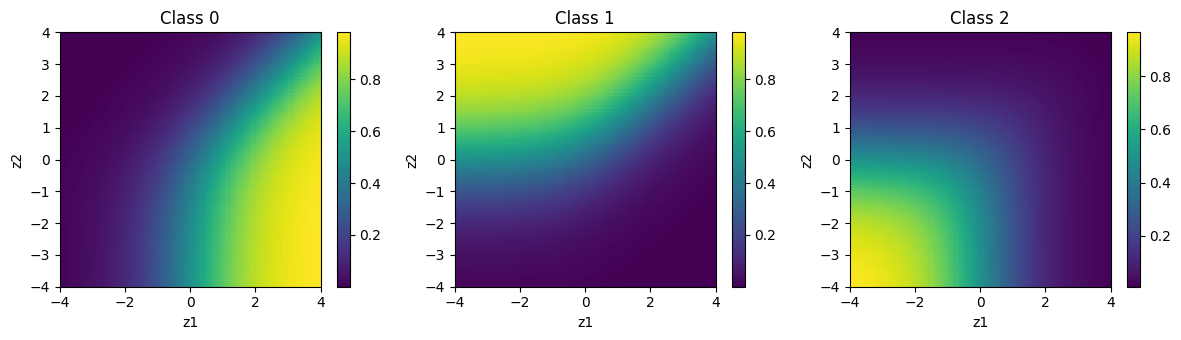

In [4]:

# Sweep z1, z2 while z3 fixed; compute probabilities for K=3
z1 = np.linspace(-4, 4, 80)
z2 = np.linspace(-4, 4, 80)
Z1, Z2 = np.meshgrid(z1, z2)
Z3 = np.zeros_like(Z1)

Z = np.stack([Z1.ravel(), Z2.ravel(), Z3.ravel()], axis=1)  # (N,3)
P = softmax(Z)  # (N,3)

P1 = P[:, 0].reshape(Z1.shape)
P2 = P[:, 1].reshape(Z1.shape)
P3 = P[:, 2].reshape(Z1.shape)

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
for ax, Pi, title in zip(axes, [P1, P2, P3], ["Class 0", "Class 1", "Class 2"]):
    im = ax.imshow(Pi, origin="lower", extent=[z1.min(), z1.max(), z2.min(), z2.max()], aspect="auto")
    ax.set_title(title)
    ax.set_xlabel("z1")
    ax.set_ylabel("z2")
    fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()



## 5. Tiny Training Demo (Synthetic 2D → 3 Classes)

Single linear layer with softmax + cross-entropy, trained using **SGD with momentum**.


In [5]:

# Synthetic dataset
rng = np.random.default_rng(1)
N_per = 60
D = 2
K = 3

centers = np.array([[2, 2], [-2, 0], [0, -2]], dtype=float)
X_list = []
y_list = []
for k in range(K):
    Xk = centers[k] + rng.normal(scale=0.8, size=(N_per, D))
    yk = np.full((N_per,), k, dtype=int)
    X_list.append(Xk); y_list.append(yk)

X = np.vstack(X_list).astype(np.float32)       # (N,2)
y = np.hstack(y_list)                          # (N,)
Y = np.eye(K)[y]                               # (N,3)

# Initialize linear layer
W = rng.normal(0, 0.1, size=(D, K)).astype(np.float32)
b = np.zeros((1, K), dtype=np.float32)

# SGD settings
lr0 = 0.1
momentum = 0.9
epochs = 40
batch_size = 64
lr_decay = 0.02

vW = np.zeros_like(W)
vb = np.zeros_like(b)

def minibatches(X, Y, bs, shuffle=True):
    n = X.shape[0]
    idx = np.arange(n)
    if shuffle:
        rng.shuffle(idx)
    for s in range(0, n, bs):
        e = min(s + bs, n)
        bi = idx[s:e]
        yield X[bi], Y[bi]

loss_hist = []
for ep in range(epochs):
    lr = lr0 / (1.0 + lr_decay * ep)
    for Xb, Yb in minibatches(X, Y, batch_size, shuffle=True):
        Z = Xb @ W + b
        P = softmax(Z)
        dZ = P - Yb
        dW = (Xb.T @ dZ) / Xb.shape[0]
        db = np.sum(dZ, axis=0, keepdims=True) / Xb.shape[0]

        vW = momentum * vW - lr * dW
        vb = momentum * vb - lr * db
        W += vW
        b += vb

        loss_hist.append(cross_entropy(Yb, P))

print(f"Final training loss: {loss_hist[-1]:.4f}")


Final training loss: 0.0340



### Loss over iterations


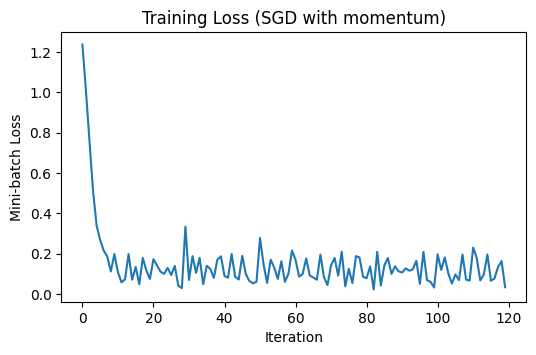

In [6]:

plt.figure(figsize=(6,3.5))
plt.plot(loss_hist)
plt.xlabel("Iteration")
plt.ylabel("Mini-batch Loss")
plt.title("Training Loss (SGD with momentum)")
plt.show()



## 6. (Optional) Softmax Probability Animation for Probe Points


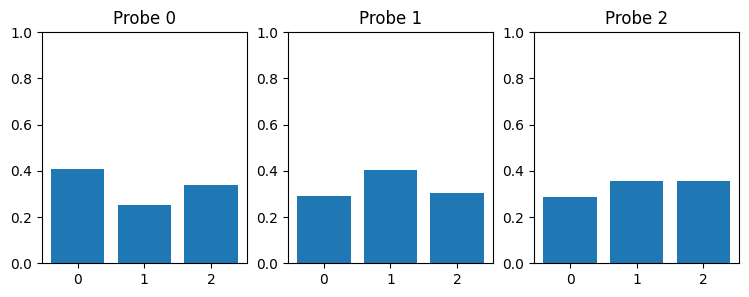

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

rng = np.random.default_rng(0)



# Select 3 probe points near each cluster center
probes = np.array([[2,2], [-2,0], [0,-2]], dtype=np.float32)  # (3,2)

# Re-run a quick training pass, recording per-iter probabilities for probes
W2 = rng.normal(0, 0.1, size=(D, K)).astype(np.float32)
b2 = np.zeros((1, K), dtype=np.float32)
vW2 = np.zeros_like(W2)
vb2 = np.zeros_like(b2)

probe_hist = []  # list of (3,K) arrays
epochs2 = 20
for ep in range(epochs2):
    lr = lr0 / (1.0 + lr_decay * ep)
    for Xb, Yb in minibatches(X, Y, batch_size, shuffle=True):
        Z = Xb @ W2 + b2
        P = softmax(Z)
        dZ = P - Yb
        dW = (Xb.T @ dZ) / Xb.shape[0]
        db = np.sum(dZ, axis=0, keepdims=True) / Xb.shape[0]

        vW2 = momentum * vW2 - lr * dW
        vb2 = momentum * vb2 - lr * db
        W2 += vW2
        b2 += vb2

        probe_hist.append(softmax(probes @ W2 + b2))

probe_hist = np.stack(probe_hist, axis=0)  # (T, 3, K)

# Animate bar charts for the 3 probe points
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
bars = []
for i, ax in enumerate(axes):
    ax.set_title(f"Probe {i}")
    ax.set_ylim(0, 1.0)
    ax.set_xticks(np.arange(K))
    bar = ax.bar(np.arange(K), probe_hist[0, i])
    bars.append(bar)

def update(frame):
    for i, bar in enumerate(bars):
        heights = probe_hist[frame, i]
        for rect, h in zip(bar, heights):
            rect.set_height(float(h))
    return [rect for bar in bars for rect in bar]

ani = animation.FuncAnimation(fig, update, frames=probe_hist.shape[0], interval=50, blit=False)
HTML(ani.to_jshtml())



## 7. Summary

- **Softmax** turns logits into probabilities; implement with a **max-shift** for stability.
- With **cross-entropy**, the gradient w.r.t. logits is $\hat{\mathbf{Y}}-\mathbf{Y}$.
- Parameter gradients are simple matrix products.
- Always do a **finite-difference gradient check** on small problems.
